In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [350]:
import torch
import torch.distributions as dist
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_1d, plot_1d_distribution
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [413]:
def p_ak_given_traj_and_z(aux_traj, z_samples, auxiliary_vars, total_var):

    b_k = torch.sum(aux_traj)
    s_k_minus_one = total_var - torch.sum(auxiliary_vars[:-1])
    s_k = s_k_minus_one - auxiliary_vars[-1]

    mean_scalar = auxiliary_vars[-1] / s_k_minus_one
    variance = auxiliary_vars[-1] * s_k / s_k_minus_one

    mean = (z_samples - b_k) * mean_scalar

    return mean, variance

def gmm_mixing_weights(aux_traj_log_probs):
    """Takes p(a_k | a_{1:k-1}, z_i) for each z_i and computes the GMM mixing weights"""
    return torch.softmax(aux_traj_log_probs, dim=0)

def q_ak_given_traj(component_means, component_vars, mixing_weights):
    
    mixing_categorical = dist.categorical.Categorical(probs=mixing_weights)
    
    component_gaussians = dist.normal.Normal(loc=component_means, scale=torch.sqrt(component_vars))
    
    gmm = dist.mixture_same_family.MixtureSameFamily(mixing_categorical, component_gaussians)
    
    return gmm

The KL between q and p is 5012.799 nats.


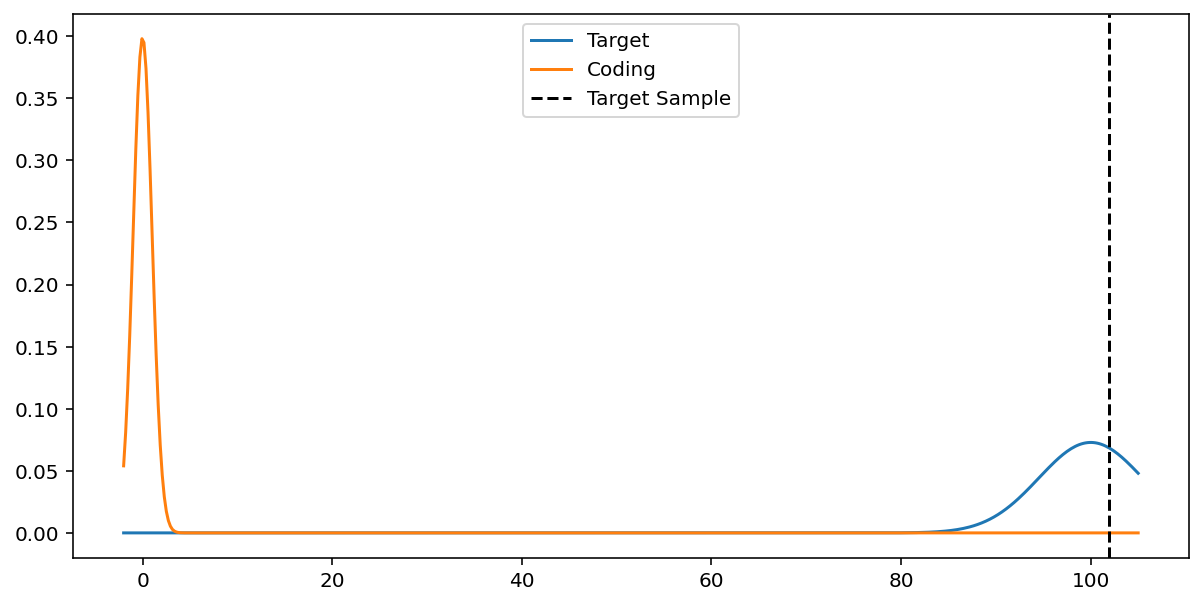

In [543]:
torch.manual_seed(100)

q_loc = 100.
q_var = 30.

p_loc = 0.
p_var = 1.

q = dist.normal.Normal(loc=q_loc, scale = math.pow(q_var, 0.5))
p = dist.normal.Normal(loc=p_loc, scale = math.pow(p_var, 0.5))

z_sample = q.sample()

total_kl = dist.kl_divergence(q, p)

print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-2., q.loc+5., 500)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')

ax.axvline(z_sample, c='k', ls='--', label='Target Sample')

ax.legend()

plt.show()

# Implementing the scheme

In [544]:
omega = 5.
epsilon = 0.
num_empirical_samples = 1
num_aux = math.ceil(total_kl / omega)
num_samples_per_aux = math.ceil(math.exp(omega * (1. + epsilon)))
print(f"The KL is {total_kl:.3f}, Omega: {omega:.0f} and epsilon is: {epsilon}."
      f"\nSo num auxiliaries: {num_aux} and num samples per aux: {num_samples_per_aux}.")

The KL is 5012.799, Omega: 5 and epsilon is: 0.0.
So num auxiliaries: 1003 and num samples per aux: 149.


## Can we guarantee the scheme will work?

For 1D the problem is simply, we need to reach the mode. What does this entail?

First we can say that to reach the mode, defined as $D$, when sampling from aux priors with 0 mean and variance $\sigma_k^2 = 1/K$ where $K$ is the number of auxiliary variables given by $\lceil\operatorname{KL}(q||p)\hspace{3pt} / \hspace{3pt} \Omega\rceil$, that on-average we need each aux var to take value $\pm D / K$, here the plus-minus refers to which sign of the mode.



In [545]:
def upper_bound_rudimentary_coding_check(kl, mode, omega):
    """
    Checks whether the scheme will work. If it doens't work, compute the necessary epsilon to make things work.
    """
    
    num_samples = math.ceil(torch.exp(torch.tensor(omega)))
    average_target_deviation = math.pow(math.ceil(kl / omega), 0.5)
    
    necessary_samples = 1. / dist.normal.Normal(loc=0., scale=1).cdf(-mode / average_target_deviation)
    
    if num_samples > necessary_samples:
        return None
    else:
        epsilon = torch.log(torch.ceil(necessary_samples)) / omega - 1
        return epsilon


In [625]:
def upper_bound_max_mean_std_normal(n):
    return torch.sqrt(torch.log(n ** 2/ (2 * pi * torch.log(n ** 2 / (2 * pi))))) * (1 + euler_mascheroni / torch.log(n))

def upper_bound_expected_value(num_aux, num_samples_per_aux):
    mean_max_std_normals = upper_bound_max_mean_std_normal(num_samples_per_aux)
    return mean_max_std_normals * (num_aux ** 0.5)

def lower_bound_rudimentary_check(kl, mode, omega):
    n = nn.Parameter(torch.tensor(float(math.ceil(math.exp(omega)))))
    n_aux = math.ceil(kl / omega)
    pi = torch.tensor(np.pi)
    e = torch.tensor(np.e)
    euler_mascheroni = torch.tensor(np.euler_gamma)
    expected_distance = upper_bound_expected_value(n_aux, n.detach())
    
    if expected_distance > mode:
        print(f"The coding scheme may work.")
        return None
    else:
        optim = torch.optim.Adam([n], lr=1.)
        loss = 10
        while loss > 1e-10:
            optim.zero_grad()
            expected_distance = upper_bound_expected_value(n_aux, n)
            loss = 0.5 * (mode - expected_distance) ** 2
            loss.backward()
            optim.step()
        necessary_epsilon = torch.log(n.detach()) / omega - 1
        return necessary_epsilon

In [620]:
def rough_epsilon_bounds(kl, mode, omega):
    epsilon_lb, epsilon_ub = lower_bound_rudimentary_check(kl, mode, omega), upper_bound_rudimentary_coding_check(kl, mode, omega)
    
    if (epsilon_lb is None) and (epsilon_ub is None):
        print(f'The Coding Scheme should work!')
    elif epsilon_lb is None:
        print(f"May need epsilon as large as: {epsilon_ub}.")
    else:
        print(f"Scheme should work with epsilon between: [{epsilon_lb:.3f}, {epsilon_ub:.3f}].")
    return epsilon_lb, epsilon_ub

In [621]:
def p_all_samples_reach(kl, mode, omega):
    n_aux = math.ceil(kl / omega)
    num_samples = math.ceil(torch.exp(torch.tensor(omega)))
    print(dist.normal.Normal(loc=0., scale=1).cdf(mode * num_aux ** 0.5))
    return 1 - dist.normal.Normal(loc=0., scale=1).cdf(mode * num_aux ** 0.5) ** num_samples

In [627]:
def bound_expected_max(kl, mode, omega, epsilon=0.):
    n_aux = math.ceil(kl / omega)
    n = torch.tensor(math.ceil(torch.exp(torch.tensor(omega * (1 + epsilon)))))
    pi = torch.tensor(np.pi)
    lb = 1./torch.sqrt(pi * torch.log(torch.tensor(2))) * (n_aux ** -0.5) * torch.sqrt(torch.log(n))
    ub = torch.sqrt(torch.log(n)) * (2 ** 0.5) * (n_aux ** -0.5)
    return lb, ub

In [628]:
e_lb, e_ub = bound_expected_max(total_kl, z_sample, omega, epsilon=0.47)

In [629]:
e_lb * num_aux, e_ub * num_aux

(tensor(58.1864), tensor(121.4295))

In [631]:
rough_epsilon_bounds(total_kl, z_sample, omega)

Scheme should work with epsilon between: [0.300, 0.470].


(tensor(0.2995), tensor(0.4705))

In [553]:
omega = 5.
epsilon = 0.35
num_empirical_samples = 1
num_aux = math.ceil(total_kl / omega)
num_samples_per_aux = math.ceil(math.exp(omega * (1. + epsilon)))
print(f"The KL is {total_kl:.3f}, Omega: {omega:.0f} and epsilon is: {epsilon}."
      f"\nSo num auxiliaries: {num_aux} and num samples per aux: {num_samples_per_aux}.")

The KL is 5012.799, Omega: 5 and epsilon is: 0.35.
So num auxiliaries: 1003 and num samples per aux: 855.


In [554]:
auxiliary_vars = p_var * torch.ones(num_aux) / num_aux
total_var = p_var

z_samples = q.sample((num_empirical_samples,))
aux_traj = torch.zeros([0])
aux_traj_mixing_weights = torch.ones((num_empirical_samples,))
aux_traj_log_q = torch.zeros(1)
aux_traj_log_p = torch.zeros(1)
biggest_sample = torch.zeros(1)
pbar = trange(1, num_aux + 1)
for i in pbar:
    #
    if i < num_aux:
        # first compute the prior
        aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[i-1], 0.5))

        # compute the posterior
        mixing_weights = gmm_mixing_weights(aux_traj_mixing_weights)

        means, variances = p_ak_given_traj_and_z(aux_traj, z_samples, auxiliary_vars[:i], total_var)
        trial_samples = aux_prior.sample((num_samples_per_aux,))

        aux_post = q_ak_given_traj(means, variances, mixing_weights)

        # sample trial aks
        trial_samples = aux_prior.sample((num_samples_per_aux,))
        
        biggest_sample += torch.max(trial_samples)

        # compute log probabilities under prior and posterior
        log_p = aux_prior.log_prob(trial_samples)
        log_q = aux_post.log_prob(trial_samples)

        # compute the joint probability of the full trajectories
        log_p_joint = log_p + aux_traj_log_p 
        log_q_joint = log_q + aux_traj_log_q

        # compute log importance sampling weight log(q/p)
        log_importance_sampling_weight = log_q_joint - log_p_joint

        # greedily choose the best weight
        best_sample_idx = torch.argmax(log_importance_sampling_weight)

        # compute the corresponding sample
        best_sample = trial_samples[best_sample_idx]

        # append to trajectory
        aux_traj = torch.cat([aux_traj, best_sample[None]])
        aux_traj_log_p += log_p[best_sample_idx]
        aux_traj_log_q += log_q[best_sample_idx]

        # compute the new mixing weights by adding new component densities to old joint component densities
        aux_traj_mixing_weights += aux_post.component_distribution.log_prob(best_sample)
    
    else:
        # last sample we complete the sum and choose best sample under q

        # first compute the prior
        aux_prior = dist.normal.Normal(loc=0., scale=math.pow(auxiliary_vars[-1], 0.5))

        # sample trial aKs
        trial_samples = aux_prior.sample((num_samples_per_aux,))
        biggest_sample += torch.max(trial_samples)
        
        # complete the sum
        final_trial_zs = torch.sum(aux_traj, dim=0) + trial_samples

        # compute log q
        log_q = q.log_prob(final_trial_zs)

        # choose best sample
        best_sample_idx = torch.argmax(log_q)

        best_sample = trial_samples[best_sample_idx]

        aux_traj = torch.cat([aux_traj, best_sample[None]])
    
    #print(f"Best sample for aux {i} was {best_sample}")
    pbar.set_description(f"Encoded Auxiliary Variable {i}")

  0%|          | 0/1003 [00:00<?, ?it/s]

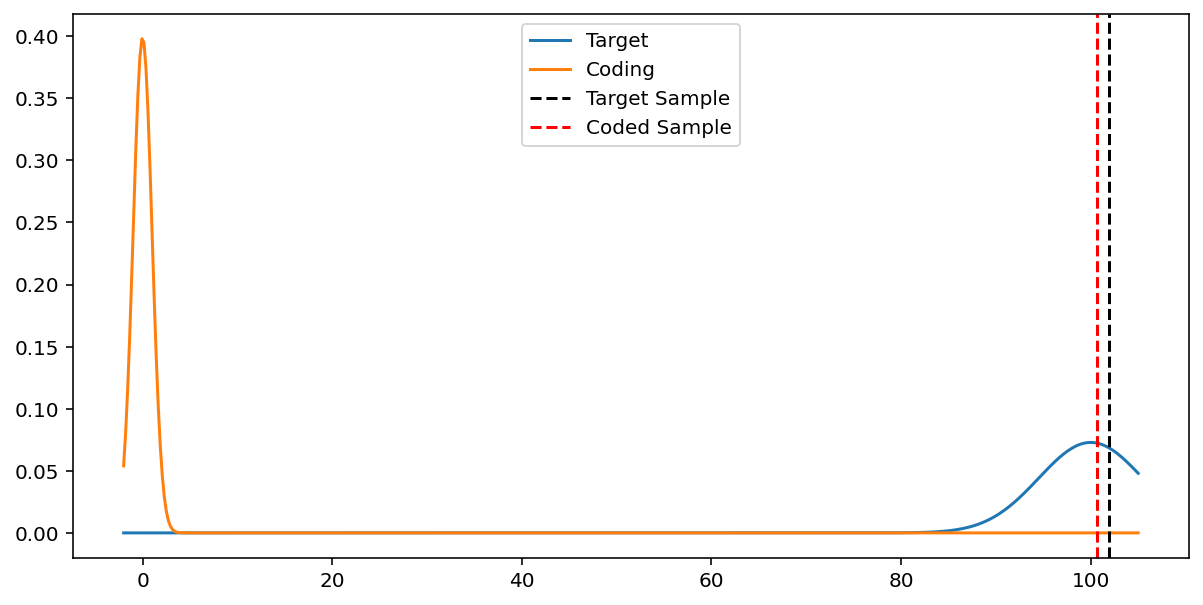

In [555]:
final_z_sum = torch.sum(aux_traj)

# ==============================
# PLOT DISTRIBUTIONS
# ==============================

xs = torch.linspace(-2., q.loc+5., 500)

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(xs, torch.exp(q.log_prob(xs)), label='Target')
ax.plot(xs, torch.exp(p.log_prob(xs)), label='Coding')

ax.axvline(z_sample, c='k', ls='--', label='Target Sample')
ax.axvline(final_z_sum, c='r', ls='--', label='Coded Sample')
ax.legend()

plt.show()

In [556]:
final_z_sum

tensor(100.7009)

In [557]:
biggest_sample

tensor([100.9098])